In [1]:
#TimeSeries 
#SlidingWindow

本資料集為2020年一整年新竹地區之空氣品質資料，我們以PM2.5為預測目標<br>
其為時間序列，故將前三季的資料做為訓練集（1-9月)，最後一季作為測試集(10-12月）<br>
用兩種模型（LinearRegressor、XGBoostRegressor）、兩種屬性數量（18、、1）做預測並作比較


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings  
warnings.filterwarnings("ignore")  

查看資料樣態，並將欄位名稱改為英文、並移除無意義的空格


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab csv/新竹_2020.csv', encoding='Big5')
df.head(5)

,測站,日期,測項,00,01,02,03,04,05,06,...,14,15,16,17,18,19,20,21,22,23
0,--------------------,--------------------,--------------------,-------------------------------,-------------------------------,-------------------------------,-------------------------------,-------------------------------,-------------------------------,-------------------------------,...,-------------------------------,-------------------------------,-------------------------------,-------------------------------,-------------------------------,-------------------------------,-------------------------------,-------------------------------,-------------------------------,-------------------------------
1,新竹,2020/01/01 00:00:00,AMB_TEMP,15.2,15.2,15.3,15.3,15.3,15.4,15.5,...,18.1,18.2,17.9,17.3,16.7,16.4,16.2,16.1,16,15.8
2,新竹,2020/01/01 00:00:00,CH4,1.74,1.74,1.77,1.78,1.77,1.77,1.77,...,1.78,1.78,1.77,1.8,1.81,1.82,1.85,1.83,1.92,1.94
3,新竹,2020/01/01 00:00:00,CO,0.28,0.25,0.24,0.22,0.2,0.19,0.2,...,0.28,0.29,0.28,0.34,0.39,0.41,0.46,0.49,0.58,0.52
4,新竹,2020/01/01 00:00:00,NMHC,0.06,0.07,0.05,0.05,0.05,0.05,0.07,...,0.09,0.09,0.07,0.08,0.12,0.12,0.16,0.14,0.17,0.2


In [5]:
df.rename(columns={'測站                  ': 'Station', 
                             '日期                  ': 'Date', 
                             '測項                  ': 'Test' }, inplace=True)
df.columns = df.columns.str.replace(' ', '')
df.columns

Index(['Station', 'Date', 'Test', '00', '01', '02', '03', '04', '05', '06',
       '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '20', '21', '22', '23'],
      dtype='object')

第一列僅為分隔線，沒意義故刪除<br>
而本資料集均為新竹地區之資料，故將測站欄位刪除


In [6]:
df.drop( df.index[:1], inplace = True) 
df.drop(['Station'],axis = 1, inplace = True)

In [7]:
df['Date'] = df['Date'].apply(lambda x: x.split(' ')[0])

乍看之下所有欄位都補好補滿，但其實存在很多符號與NAN，且資料均為類別型態

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6588 entries, 1 to 6588
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    6588 non-null   object
 1   Test    6588 non-null   object
 2   00      6588 non-null   object
 3   01      6588 non-null   object
 4   02      6588 non-null   object
 5   03      6588 non-null   object
 6   04      6588 non-null   object
 7   05      6588 non-null   object
 8   06      6588 non-null   object
 9   07      6588 non-null   object
 10  08      6588 non-null   object
 11  09      6588 non-null   object
 12  10      6588 non-null   object
 13  11      6588 non-null   object
 14  12      6588 non-null   object
 15  13      6588 non-null   object
 16  14      6588 non-null   object
 17  15      6588 non-null   object
 18  16      6588 non-null   object
 19  17      6588 non-null   object
 20  18      6588 non-null   object
 21  19      6588 non-null   object
 22  20      6588 non-null   

本資料集包含許多符號及空格，將之以空白代換，並將類別欄位均轉成數值型態以利分析

NR表示無降雨，以0取代


In [9]:
invalid = ['#                              ','*                              ','x                              ','A                              ', ' ']

for i in invalid:
  df=df.apply(lambda x : x.replace(i,''))

df=df.apply(lambda x : x.replace( 'NR', 0 )) 

In [10]:
df['Test']=df['Test'].apply(lambda x : x.replace(' ',''))
print(df['Test'].unique())
print('Test item num: ',len(df['Test'].unique()))

['AMB_TEMP' 'CH4' 'CO' 'NMHC' 'NO' 'NO2' 'NOx' 'O3' 'PM10' 'PM2.5'
 'RAINFALL' 'RH' 'SO2' 'THC' 'WD_HR' 'WIND_DIREC' 'WIND_SPEED' 'WS_HR']
Test item num:  18


原始資料以小時（0-23）當作當作colums，檢測項目放在放在row<br>
先將相同的檢測項目整理在一起，再將檢測項目轉為columns、小時為row

In [11]:
 for i in ( '00','01','02','03','04','05','06','07','08','09','10', '11','12','13','14','15','16','17','18','19','20','21','22','23'):
     df[i] = pd.to_numeric(df[i],errors='coerce')

In [12]:
df_test = pd.DataFrame()
for item in df['Test'].unique():
  group = df.groupby('Test')
  df_test = pd.concat([df_test, group.get_group(item)])

df_test.reset_index(drop = True)

,Date,Test,00,01,02,03,04,05,06,07,...,14,15,16,17,18,19,20,21,22,23
0,2020/01/01,AMB_TEMP,15.2,15.2,15.3,15.3,15.3,15.4,15.5,15.8,...,18.1,18.2,17.9,17.3,16.7,16.4,16.2,16.1,16.0,15.8
1,2020/01/02,AMB_TEMP,15.7,14.9,15.1,14.8,14.4,14.3,14.2,14.8,...,22.5,22.2,21.4,20.5,20.1,19.7,19.3,18.4,18.0,17.5
2,2020/01/03,AMB_TEMP,17.0,16.6,16.1,15.5,15.1,14.8,14.6,14.9,...,23.0,22.6,21.8,20.7,20.2,19.7,19.2,19.1,18.6,18.0
3,2020/01/04,AMB_TEMP,17.5,17.1,16.9,16.7,16.5,16.9,17.3,17.5,...,22.0,22.7,22.7,21.6,21.2,20.8,20.4,20.0,19.1,18.8
4,2020/01/05,AMB_TEMP,18.6,18.3,17.9,18.3,18.5,18.6,18.4,18.2,...,22.9,23.1,22.8,21.5,20.7,20.5,20.1,19.9,19.7,19.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6583,2020/12/27,WS_HR,1.4,1.0,1.0,0.7,0.8,1.0,0.8,0.9,...,1.2,1.4,1.8,1.4,1.5,1.0,1.2,1.4,1.3,1.3
6584,2020/12/28,WS_HR,1.8,1.7,2.0,2.5,3.0,2.8,3.0,3.1,...,2.6,2.5,1.9,2.1,1.5,1.3,1.1,0.7,0.4,0.7
6585,2020/12/29,WS_HR,0.6,0.6,0.1,0.6,0.4,0.7,0.5,0.3,...,0.8,1.2,1.1,1.4,1.4,1.3,1.4,1.7,1.7,1.9
6586,2020/12/30,WS_HR,3.1,4.2,4.5,3.8,4.8,4.7,4.7,4.3,...,3.9,3.8,4.1,3.8,2.8,2.8,3.1,2.6,3.1,3.7


In [13]:
clm_need=[]
for clm_name in df.columns:
  if len(clm_name) <3:
    clm_need.append(clm_name)
#clm_need

In [14]:
df_time = pd.DataFrame()
list_ts = []
for item in df_test['Test'].unique():
  for idx in df_test[df_test['Test'].eq(item)][clm_need].index:
    list_ts.extend(df_test[df_test['Test'].eq(item)][clm_need].loc[idx])
  df_time[item] = list_ts
  list_ts.clear()
df_time

,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,15.2,1.74,0.28,0.06,0.3,6.7,7.0,33.1,36.0,21.0,0.0,74.0,1.0,1.80,47.0,43.0,3.7,3.3
1,15.2,1.74,0.25,0.07,0.6,6.9,7.5,33.4,28.0,8.0,0.0,74.0,1.0,1.81,52.0,48.0,2.8,2.7
2,15.3,1.77,0.24,0.05,0.6,6.4,6.9,33.5,22.0,8.0,0.0,73.0,1.0,1.82,44.0,48.0,3.5,2.6
3,15.3,1.78,0.22,0.05,0.6,5.9,6.5,32.6,19.0,8.0,0.0,74.0,0.5,1.83,43.0,56.0,3.1,2.5
4,15.3,1.77,0.20,0.05,0.3,4.8,5.3,33.5,14.0,9.0,0.0,77.0,0.5,1.82,46.0,56.0,3.0,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,10.6,1.99,0.31,0.08,1.6,10.8,12.4,28.4,31.0,13.0,0.0,61.0,NaN,2.07,42.0,40.0,4.7,3.3
8780,10.8,1.98,0.29,0.09,1.5,9.3,10.8,28.9,27.0,12.0,0.0,61.0,NaN,2.07,42.0,46.0,4.5,3.1
8781,10.9,1.98,0.28,0.07,1.5,8.6,10.2,29.5,26.0,15.0,0.0,60.0,NaN,2.05,47.0,46.0,4.4,2.9
8782,11.0,1.97,0.26,0.07,1.4,7.7,9.1,29.7,23.0,18.0,0.0,60.0,NaN,2.04,45.0,51.0,3.9,2.8


將有缺失值的欄位以其前後一小時的平均做差補，並確認所有欄位皆無空值，且均為數值型態

In [15]:
df_time.interpolate( method ='linear', axis = 1, inplace = True)
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AMB_TEMP    8772 non-null   float64
 1   CH4         8772 non-null   float64
 2   CO          8772 non-null   float64
 3   NMHC        8772 non-null   float64
 4   NO          8772 non-null   float64
 5   NO2         8772 non-null   float64
 6   NOx         8772 non-null   float64
 7   O3          8772 non-null   float64
 8   PM10        8778 non-null   float64
 9   PM2.5       8778 non-null   float64
 10  RAINFALL    8779 non-null   float64
 11  RH          8779 non-null   float64
 12  SO2         8779 non-null   float64
 13  THC         8779 non-null   float64
 14  WD_HR       8779 non-null   float64
 15  WIND_DIREC  8779 non-null   float64
 16  WIND_SPEED  8779 non-null   float64
 17  WS_HR       8779 non-null   float64
dtypes: float64(18)
memory usage: 1.2 MB


將前三季作為訓練集，最後一季作為測試集

In [16]:
train_hours = len( df['Date'].between('2020/1/1' , '2020/9/30'))
test_hours = len( df['Date'].between('2020/10/1' , '2020/12/31'))
print( 'train_hour:{}, test_hour:{}'.format(train_hours, test_hours))

train_hour:6588, test_hour:6588


In [17]:
train_hours = df_time[0:6588]
test_hours = df_time[6588:] 

欲比較全部屬性與單一屬性做預測之差異，故將資料做兩種處理<br>
數字表示使用的屬性數量

In [18]:
X_train_18 = train_hours 
y_train_18 = train_hours['PM2.5'].values.reshape(-1, 1)

X_test_18 = test_hours
y_test_18 = test_hours['PM2.5'].values.reshape(-1, 1)

In [19]:
X_train_1 = train_hours['PM2.5'].values.reshape(-1, 1) 
y_train_1 = train_hours['PM2.5'].values.reshape(-1, 1)

X_test_1 = test_hours['PM2.5'].values.reshape(-1, 1) 
y_test_1 = test_hours['PM2.5'].values.reshape(-1, 1)

In [20]:
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [21]:
def train_model( X_train,y_train, window_len):
  for hour in range( len(X_train)-window_len):
    lr = LinearRegression( )
    xgr = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, eta=1e-4)
    X_train = X_train[hour: hour+window_len ]
    y_train = y_train[hour : hour+window_len ]

    lr.fit(X_train, y_train)
    xgr.fit(X_train, y_train)
    return lr, xgr

def plot_result(y_test, y_pred_1, mse_1, mae_1, y_pred_2, mse_2, mae_2, window_len):
  plt.figure(figsize = (16, 5), dpi = 72)
  plt.subplots_adjust (wspace = 0.1)
  plt.subplot(121)  
  plt.plot(y_pred_1, label='Pred', c ='r')
  plt.plot(y_test, label='True', c='b')
  plt.title(f'LinearRegressor\nWindow_size: {window_len}  MSE: {mse_1:.4f}  MAE: {mae_1:.4f}')
  plt.legend(loc='upper left')

  plt.subplot(122)  
  plt.plot(y_pred_2, label='Pred', c ='r')
  plt.plot(y_test, label='True', c='b')
  plt.title(f'XGBoostRegressor\nWindow_size: {window_len}  MSE: {mse_2:.4f}  MAE: {mae_2:.4f}')
  plt.legend(loc='upper left')

def pred_eva ( X_test, y_test, num_feature, model1, model2):
  y_pred_1= model1.predict(X_test)
  mae_1 = mean_absolute_error( y_test, y_pred_1 )
  mse_1 = mean_squared_error( y_test, y_pred_1 )

  y_pred_2= model2.predict(X_test)
  mae_2 = mean_absolute_error( y_test, y_pred_2 )
  mse_2 = mean_squared_error( y_test, y_pred_2 )
  print(f'{num_feature}個屬性:\n   Linear_Regression:  MSE = {mse_1:.6f}      MAE = {mae_1:.6f}\n   XGBoost_Regressor:  MSE = {mse_2:.6f}    MAE = {mae_2:.6f}\n ')
  plot_result(y_test, y_pred_1, mse_1, mae_1, y_pred_2, mse_2, mae_2, win_size)
  return y_pred_1, mse_1, mae_1, y_pred_2, mse_2, mae_2 
  


用不同窗格長度&屬性數量訓練模型，比較其預測差異<br>
十八個屬性時：

可以發現，當窗格長度超過12HR，LinearRegressor預測表現良好，MSE & MAE皆非常小<br>
窗格長度更長時甚至到小數點以下六位都是零<br>
從圖來看更為清楚：<br>
左圖為LinearRegressor、右圖為XGBoostRegreoosr<br>
紅線為預測、藍線為實際，兩條線幾乎貼合在一起


XGBoostRegresso同樣在窗格超過12HR後預測表現明顯改善，但仍遠遠不及LinearRegressor

-------------------Window_size: 6 ------------------
18個屬性:
   Linear_Regression:  MSE = 19.983421      MAE = 3.077347
   XGBoost_Regressor:  MSE = 61.966693    MAE = 6.058998
 
-------------------Window_size: 12 ------------------
18個屬性:
   Linear_Regression:  MSE = 0.006363      MAE = 0.058941
   XGBoost_Regressor:  MSE = 29.175848    MAE = 3.192216
 
-------------------Window_size: 18 ------------------
18個屬性:
   Linear_Regression:  MSE = 0.000000      MAE = 0.000000
   XGBoost_Regressor:  MSE = 28.366283    MAE = 2.999502
 
-------------------Window_size: 24 ------------------
18個屬性:
   Linear_Regression:  MSE = 0.000000      MAE = 0.000000
   XGBoost_Regressor:  MSE = 28.123432    MAE = 2.935924
 
-------------------Window_size: 36 ------------------
18個屬性:
   Linear_Regression:  MSE = 0.000000      MAE = 0.000000
   XGBoost_Regressor:  MSE = 25.111556    MAE = 2.541525
 


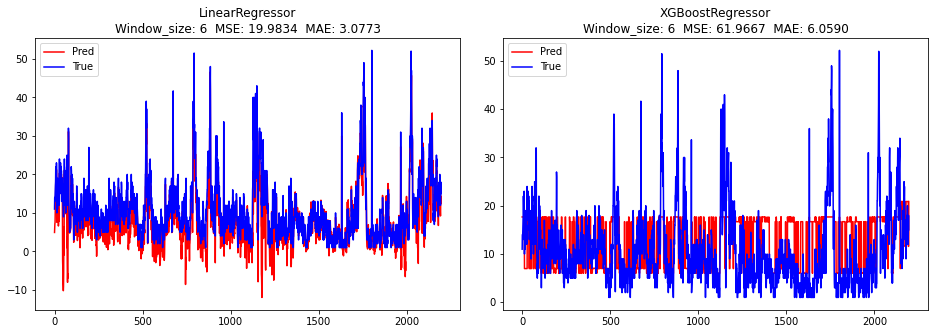

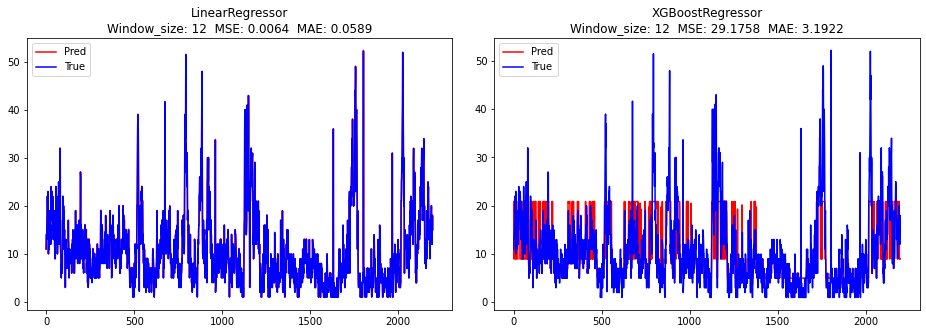

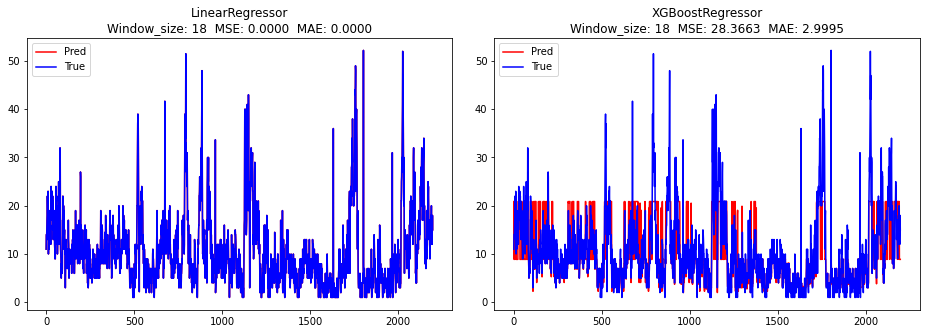

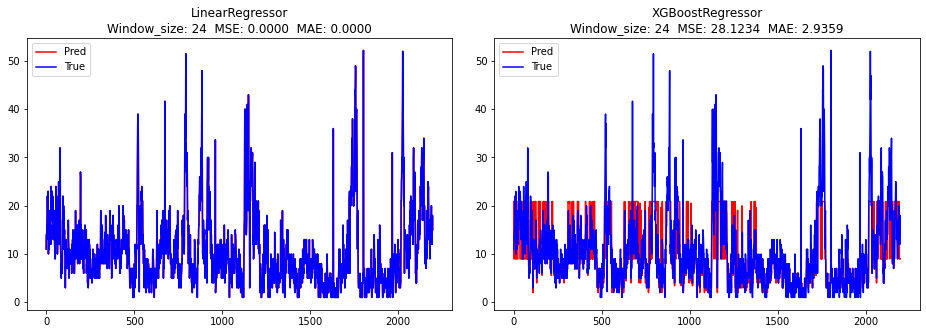

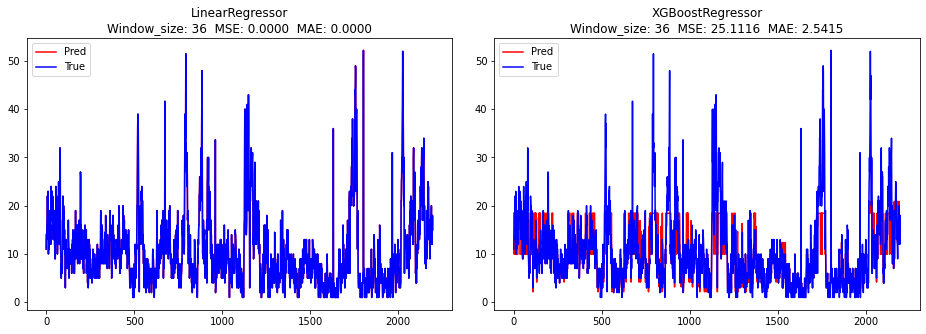

In [22]:
window_len = [ 6, 12 , 18 ,24, 36]
for win_size in window_len:
  print('-------------------Window_size:', win_size,'------------------')
  lr, xgr = train_model(X_train_18, y_train_18, win_size)
  lr_y_pred, lr_mse, lr_mae, xgr_y_pred, xgr_mse, xgr_mae =pred_eva ( X_test_18, y_test_1, 18, lr , xgr)

僅使用單一屬性PM2.5時：

情況與使用十八個屬性時類似，LinearRegressor表現遠遠優於XGBoostRegressor<br>
但兩種方法的預測表現均大幅提升，符合傳統上認為時間序列單一屬性做預測表現較好之現象。


另外，經過多種比較後發現，本資料集使用簡單的線性回歸就能很好的預測未來PM2.5的狀況，<br>而使用XGBoostRegressor反而使誤差明顯大增，經過多次調整參數後情況並無顯著改善，有點殺雞焉月牛刀的感覺。

-------------------Window_size: 6 -------------------
1個屬性:
   Linear_Regression:  MSE = 0.000000      MAE = 0.000000
   XGBoost_Regressor:  MSE = 17.745476    MAE = 2.595706
 
-------------------Window_size: 12 -------------------
1個屬性:
   Linear_Regression:  MSE = 0.000000      MAE = 0.000000
   XGBoost_Regressor:  MSE = 16.540240    MAE = 2.242504
 
-------------------Window_size: 18 -------------------
1個屬性:
   Linear_Regression:  MSE = 0.000000      MAE = 0.000000
   XGBoost_Regressor:  MSE = 15.431074    MAE = 1.865743
 
-------------------Window_size: 24 -------------------
1個屬性:
   Linear_Regression:  MSE = 0.000000      MAE = 0.000000
   XGBoost_Regressor:  MSE = 15.431476    MAE = 1.865839
 
-------------------Window_size: 36 -------------------
1個屬性:
   Linear_Regression:  MSE = 0.000000      MAE = 0.000000
   XGBoost_Regressor:  MSE = 14.208937    MAE = 1.620963
 


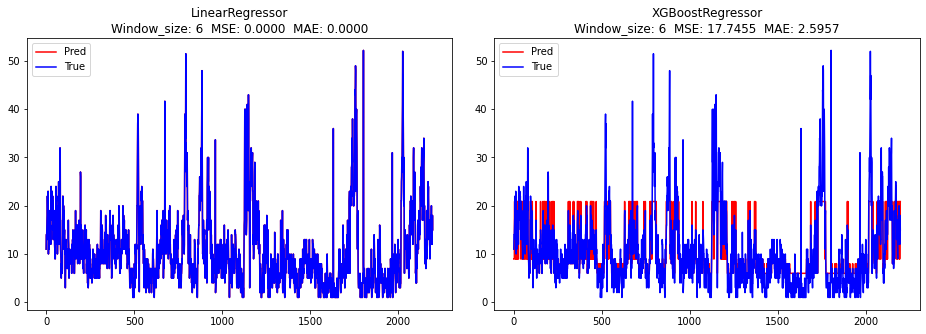

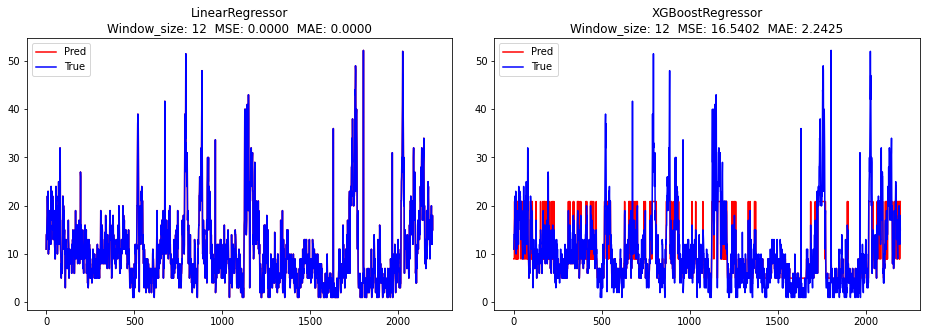

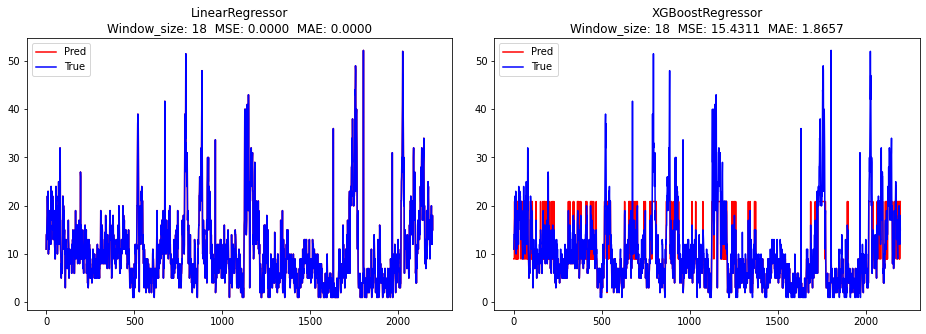

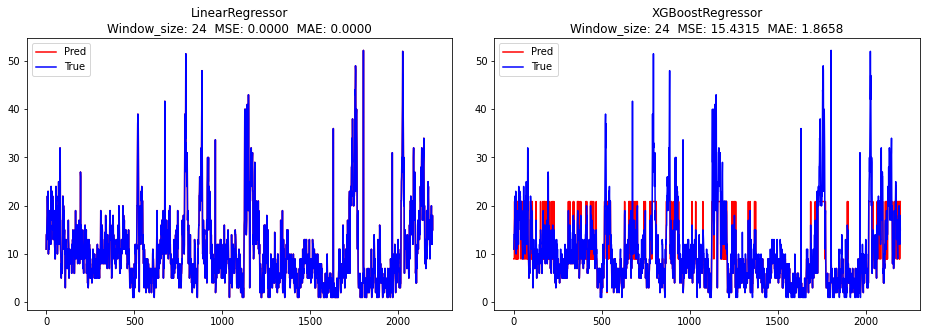

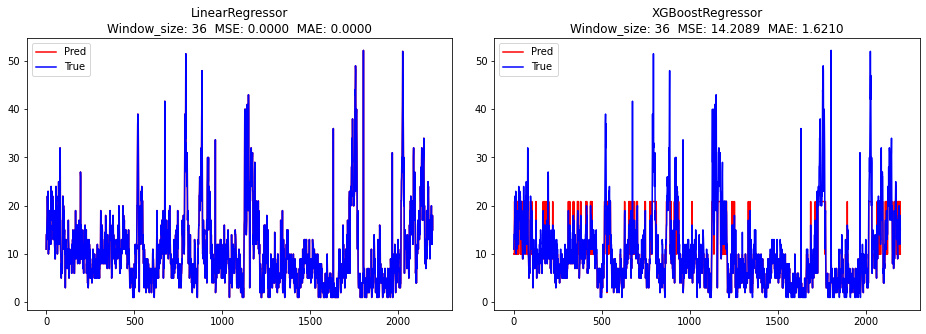

In [23]:
for win_size in window_len:
  print('-------------------Window_size:', win_size,'-------------------')
  lr, xgr = train_model(X_train_1, y_train_1, win_size)
  lr_y_pred, lr_mse, lr_mae, xgr_y_pred, xgr_mse, xgr_mae =pred_eva ( X_test_1, y_test_1, 1, lr , xgr)
